# Aanvraag / besluit classifier

In [1]:
cd ../..

/home/simulation/stadsarchief


In [2]:
# Debug commands to see if Tensorflow GPU is supported
# from keras import backend as K
# print(K.tensorflow_backend._get_available_gpus())

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
import numpy as np
import time
import math
from PIL import Image
from scipy import misc
import shutil
import keras
import keras.backend as K
import keras_metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve
import pandas as pd
import os

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
 
from examples.aanvraag_besluit.load_data import load_data_aanvraag

from src.stats import list_stats, show_train_curves, show_prediction_list, show_prediction_images
from src.data import split_data
from src.image_display import show_image
from src import models as own_models
from src.processing.TargetEncoder import TargetEncoder
from src.processing.ImageFeatureEncoder import ImageFeatureEncoder

# Hot reload packages
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [4]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [5]:
# Set tensorflow GPU memory usage to on the fly rather than preallocate.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

## Model, weights and transformations persistence

In [5]:
MODEL_DIR='./output/model/'
TRANSFORM_DIR=os.path.join('transform/')
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TRANSFORM_DIR, exist_ok=True)

## Load dataset

In [6]:
img_dim = (200, 200, 3);
img_dim = (250, 250, 3);
# img_dim = (300, 300, 3);
# img_dim = (400, 400, 3);

idsSkip = [
    # Images are not loaded properly
    'ST00122908_00001',
    'ST00058502_00001'
]

[
    [Xtrain_raw, Ytrain_raw, Ztrain_raw],
    [Xvalid_raw, Yvalid_raw, Zvalid_raw],
    _test,
] = load_data_aanvraag(
    inputs = [
        {
            'images': f'examples/aanvraag_besluit/eerste_dataset/resized/{img_dim[0]}x{img_dim[1]}/',
            'labels': 'examples/aanvraag_besluit/eerste_dataset/labels/'
        },
        {
            'images': f'examples/aanvraag_besluit/tweede_dataset/images/{img_dim[0]}x{img_dim[1]}/',
            'labels': 'examples/aanvraag_besluit/tweede_dataset/labels/'
        }
    ],
    inputs_train_only = [
        {
            'images': f'examples/aanvraag_besluit/derde_dataset/images/{img_dim[0]}x{img_dim[1]}/',
            'labels': 'examples/aanvraag_besluit/derde_dataset/labels/'
        }
    ],
    skip=idsSkip
)

print(f"shape Xtrain: {Xtrain_raw.shape}")
print(f"shape Ytrain: {Ytrain_raw.shape}")
print(f"shape Ztrain: {Ztrain_raw.shape}")

print(f"shape Xvalid: {Xvalid_raw.shape}")
print(f"shape Yvalid: {Yvalid_raw.shape}")
print(f"shape Zvalid: {Zvalid_raw.shape}")


print("not using (hold out) test set of shape: ", _test[0].shape)

--- loading set:  {'images': 'examples/aanvraag_besluit/eerste_dataset/resized/250x250/', 'labels': 'examples/aanvraag_besluit/eerste_dataset/labels/'}
first few ids: ['SA00355769_00001', 'SU10011027_00001', 'SU10108703_00001', 'SU10089176_00001', 'SA00483623_00001']
last few ids: ['SU10016152_00001', 'SU10061830_00001', 'SQ10004104_00001', 'SA00023173_00001', 'SU10098898_00001']
ids count: 412
ids with label count: 412
loading yaml filtered
type of nparray: uint8
73.671MB
shape this set Img: (412, 250, 250, 3)
--- loading set:  {'images': 'examples/aanvraag_besluit/tweede_dataset/images/250x250/', 'labels': 'examples/aanvraag_besluit/tweede_dataset/labels/'}
first few ids: ['SU10125259_00001', 'SU10223433_00001', 'SU10209548_00001', 'SU10125532_00001', 'SU10127409_00001']
last few ids: ['SU10154653_00001', 'SU10253561_00001', 'SU10142314_00001', 'SU10276930_00001', 'SU10248722_00001']
ids count: 1577
ids with label count: 1009
loading yaml filtered
type of nparray: uint8
180.423MB
sha

In [7]:
# ids = Yvalid_raw['reference'] == 'SU10212124_00001.jpg'
# print(Xvalid_raw.loc[ids])
# Yvalid_raw[ids]

In [9]:
# # Expand input data to 10,000 examples
# print("before")
# print(Xtrain_raw[0].shape)
# print(Xtrain_raw[1].shape)
# Xtrain_raw[0] = np.tile(Xtrain_raw[0], (15, 1, 1, 1))
# Xtrain_raw[1] = np.tile(Xtrain_raw[1], (15, 1))

# print("after")
# print(Xtrain_raw[0].shape)
# print(Xtrain_raw[1].shape)

In [10]:
print(f'{Xtrain_raw.nbytes / 1024**2}MB')
Xtrain_raw.dtype

1947.1049308776855MB


dtype('uint8')

## Preprocess
### feature preprocessing

In [11]:
## Meta data AND image transformations
# # Preprocess (encode, transform features and labels)
# transformer = Transformer()

# Xdata_mix = Xtrain_raw[1].append(Xvalid_raw[1])
# transformer.fit(Xdata_mix)

# Xtrain = preprocess_X(Xtrain_raw[0], Xtrain_raw[1], transformer)
# Xvalid = preprocess_X(Xvalid_raw[0], Xvalid_raw[1], transformer)
# # print(Xtrain[1][:4])
# # print(transformer.decode(Xtrain[1][:4]))
# print(Xvalid[1][:4])
# print(transformer.decode(Xvalid[1][:4]))

# num_features = Xtrain[1].shape[1]
# print(Xvalid[1].shape)
# assert Xvalid[1].shape[1] == num_features
# del Xdata_mix

# Preprocess (encode, transform features and labels)

imageEncoder = ImageFeatureEncoder()

imageEncoder.fit(Xtrain_raw)
print('fitted')

Xtrain = imageEncoder.transform(Xtrain_raw)
Xvalid = imageEncoder.transform(Xvalid_raw)
print('Xtrain.shape: ', Xtrain.shape)
print('Xvalid.shape: ', Xvalid.shape)

# print(Xvalid[:4])
imageEncoder.save(TRANSFORM_DIR)

fitted
Xtrain.shape:  (10889, 250, 250, 3)
Xvalid.shape:  (469, 250, 250, 3)


In [12]:
print(f'{Xtrain.nbytes / 1024**2}MB')
Xtrain.dtype

3894.209861755371MB


dtype('float16')

### Label preprocessing

In [13]:
classes = list(set(Ztrain_raw.ravel()))
print(classes)
num_classes = 2
assert len(classes) == num_classes


print('')
print('--- TRAIN ---')
list_stats(Ztrain_raw.ravel())

print('')
print('--- VALID ---')
list_stats(Zvalid_raw.ravel())

['aanvraag', 'other']

--- TRAIN ---
classes: 2
classes with count less than 5 ignored
count classes: [['aanvraag', 4425], ['other', 6464]]
largest class: other, count: 6464
total count: 10889
score to beat: 0.5936265956469832

--- VALID ---
classes: 2
classes with count less than 5 ignored
count classes: [['aanvraag', 162], ['other', 307]]
largest class: other, count: 307
total count: 469
score to beat: 0.6545842217484008


In [14]:
# enc = preprocessing.LabelEncoder()  # outputs 1d array, binary classification
encoder = TargetEncoder()

# assert Ztrain_raw.ndim == 1
encoder.fit(Ztrain_raw)

print('Ztrain_raw shape: ', Ztrain_raw.shape)
print('Ztrain_raw[:10]: ', Ztrain_raw[:10])

Ztrain = encoder.transform(Ztrain_raw).toarray()
Zvalid = encoder.transform(Zvalid_raw).toarray()
print('Ztrain: ', Ztrain.shape)
print('Zvalid: ', Zvalid.shape)
print('Ztrain: ', Ztrain[:10])

print(f'inverse transform for example: {encoder.inverse_transform([[1, 0.5]])}')

encoder.save(TRANSFORM_DIR)

Ztrain_raw shape:  (10889, 1)
Ztrain_raw[:10]:  [['other']
 ['aanvraag']
 ['other']
 ['other']
 ['aanvraag']
 ['other']
 ['aanvraag']
 ['aanvraag']
 ['other']
 ['other']]
Ztrain:  (10889, 2)
Zvalid:  (469, 2)
Ztrain:  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
inverse transform for example: [['aanvraag']]


# Define model

In [15]:
# model = own_models.build_multi_feature(num_classes, img_dim, num_features)
model = own_models.create_cnn(img_dim, num_classes)
# model = own_models.create_cnn_deep(img_dim, num_classes)
# model = own_models.create_mlp(num_features, num_classes)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-cnn (InputLayer)       (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 248, 248, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
__________

# Train

In [ ]:
batch_size = 20
epochs = 100

run_name = '/cnn_drie_datasets_heavy_augmentation_lr00003'
LOG_DIR = f'./logs{run_name}'
shutil.rmtree(LOG_DIR, ignore_errors=True)

datagen = ImageDataGenerator(
        zoom_range=0.15,        # randomly zoom into images
        rotation_range=15,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.15, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,# randomly shift images vertically (fraction of total height)
        shear_range=4.0,  # in degrees
        channel_shift_range=0.15,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False    # randomly flip images
)

tbCallBack = keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=0,
    write_graph=True,
    write_images=True
)

terminateCB = tf.keras.callbacks.TerminateOnNaN()


def is_binary(model):
    n_classes = model.get_layer('output').output_shape[1]
    return n_classes == 1
    
def compile_model(model):
    assert(K.image_data_format() == 'channels_last')
    
#     if is_binary(model):
#         loss= keras.losses.binary_crossentropy
#     else:
    loss=keras.losses.categorical_crossentropy
    
    model.compile(
        loss=loss,
#         optimizer=keras.optimizers.Adadelta(),
#         optimizer='rmsprop',
#         optimizer='sgd',
#         optimizer=keras.optimizers.SGD(lr=0.01),
#         optimizer=keras.optimizers.Adam(),        
#         optimizer=keras.optimizers.Adam(lr=0.0003),
#         optimizer=keras.optimizers.Adam(lr=0.0001),
        optimizer=keras.optimizers.Adam(lr=0.00003),
#         metrics=['accuracy', keras_metrics.recall()]
        metrics=['accuracy', keras_metrics.binary_recall(label=0)]

    )

def train(model, X_train, Z_train, X_valid, Z_valid, batch_size, epochs):
    compile_model(model)
    
    history = model.fit(X_train, Z_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_valid, Z_valid),
              callbacks=[tbCallBack, terminateCB]
           )
    return history

def train_gen(model, X_train, Z_train, X_valid, Z_valid, batch_size, epochs):
    compile_model(model)

#     with tf.Session() as s:
#         s.run(tf.global_variables_initializer())
    history = model.fit_generator(
        datagen.flow(X_train,
                     Z_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_valid, Z_valid),
        workers=4,
        callbacks=[tbCallBack, terminateCB]
    )
    return history

t0 = time.time()

# model = own_models.create_cnn_deep_d(img_dim, num_classes)

# Combined data
# history = train(model, Xtrain, Ytrain, Xvalid, Yvalid, batch_size, epochs)

# Meta data
# model = own_models.create_mlp(num_features, num_classes)
# history = train(model, Xtrain[1], Ytrain, Xvalid[1], Yvalid, batch_size, epochs)

# Img data
model = own_models.create_cnn(img_dim, num_classes)
# history = train(model, Xtrain[0], Ytrain, Xvalid[0], Yvalid, batch_size, epochs)
history = train_gen(model, Xtrain, Ztrain, Xvalid, Zvalid, batch_size, epochs)

show_train_curves(history)

difference = time.time() - t0
print(f'time: {difference} seconds')

In [21]:
train_score = model.evaluate(Xtrain, Ztrain, verbose=1)
print('Train loss:', round(train_score[0], 3))
print(f'Train accuracy: {round(train_score[1] * 100, 2)}%')

valid_score = model.evaluate(Xvalid, Zvalid, verbose=1)
print('Test loss:', round(valid_score[0], 3))
valid_acc_str = f'{round(valid_score[1] * 100, 2)}%'
print(f'Test accuracy: {valid_acc_str}')

10889/10889 [==============================] - 31s 3ms/step
Train loss: 0.074
Train accuracy: 97.73%
469/469 [==============================] - 1s 3ms/step
Test loss: 0.165
Test accuracy: 94.88%


In [22]:
print(f"types: {classes}")

print("train predictions, truth")
predictions_train =  model.predict(Xtrain, verbose=1)
show_prediction_list(predictions_train, Ztrain)

print("test predictions, truth")
predictions_valid = model.predict(Xvalid, verbose=1)
show_prediction_list(predictions_valid, Zvalid)

types: ['other', 'aanvraag']
train predictions, truth
10889/10889 [==============================] - 30s 3ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0]
expected:   [1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0]
test predictions, truth
469/469 [==============================] - 1s 3ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1]
expected:   [0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1]


In [ ]:
idx = 11
id = Yvalid_raw[idx, 2]
image = Xvalid_raw[idx]
print(id)
show_image(image)

train set:


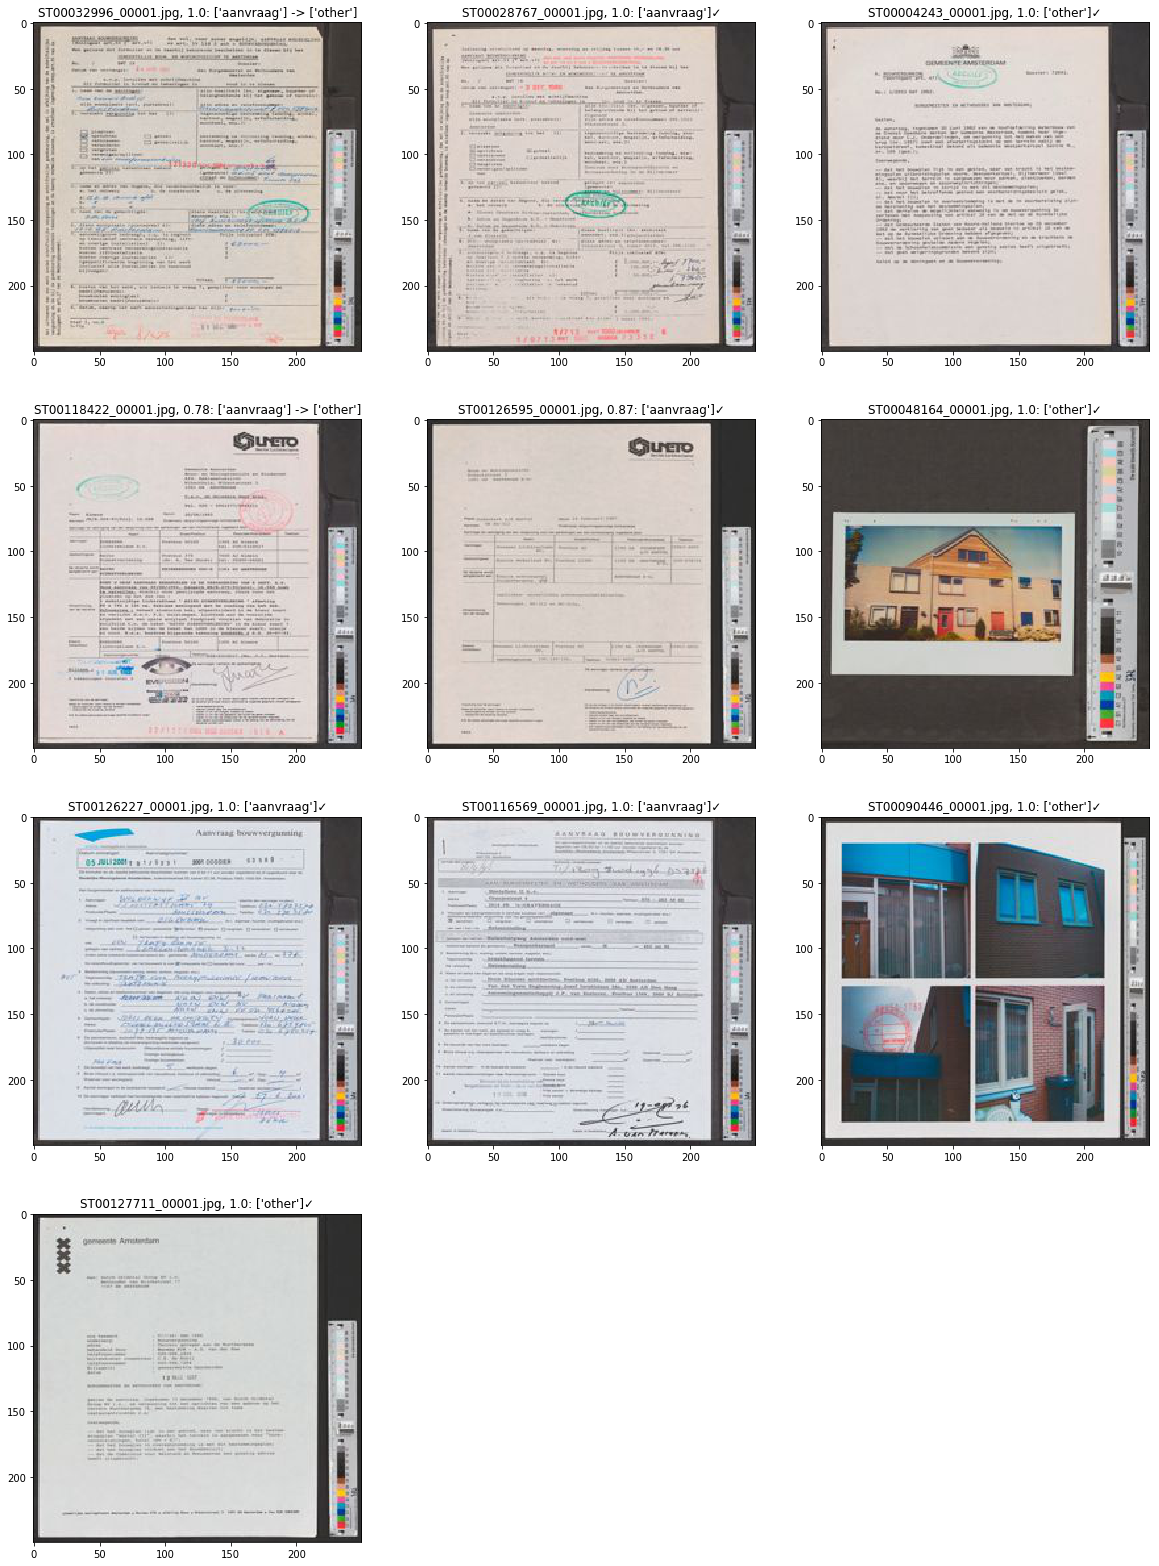

test set:


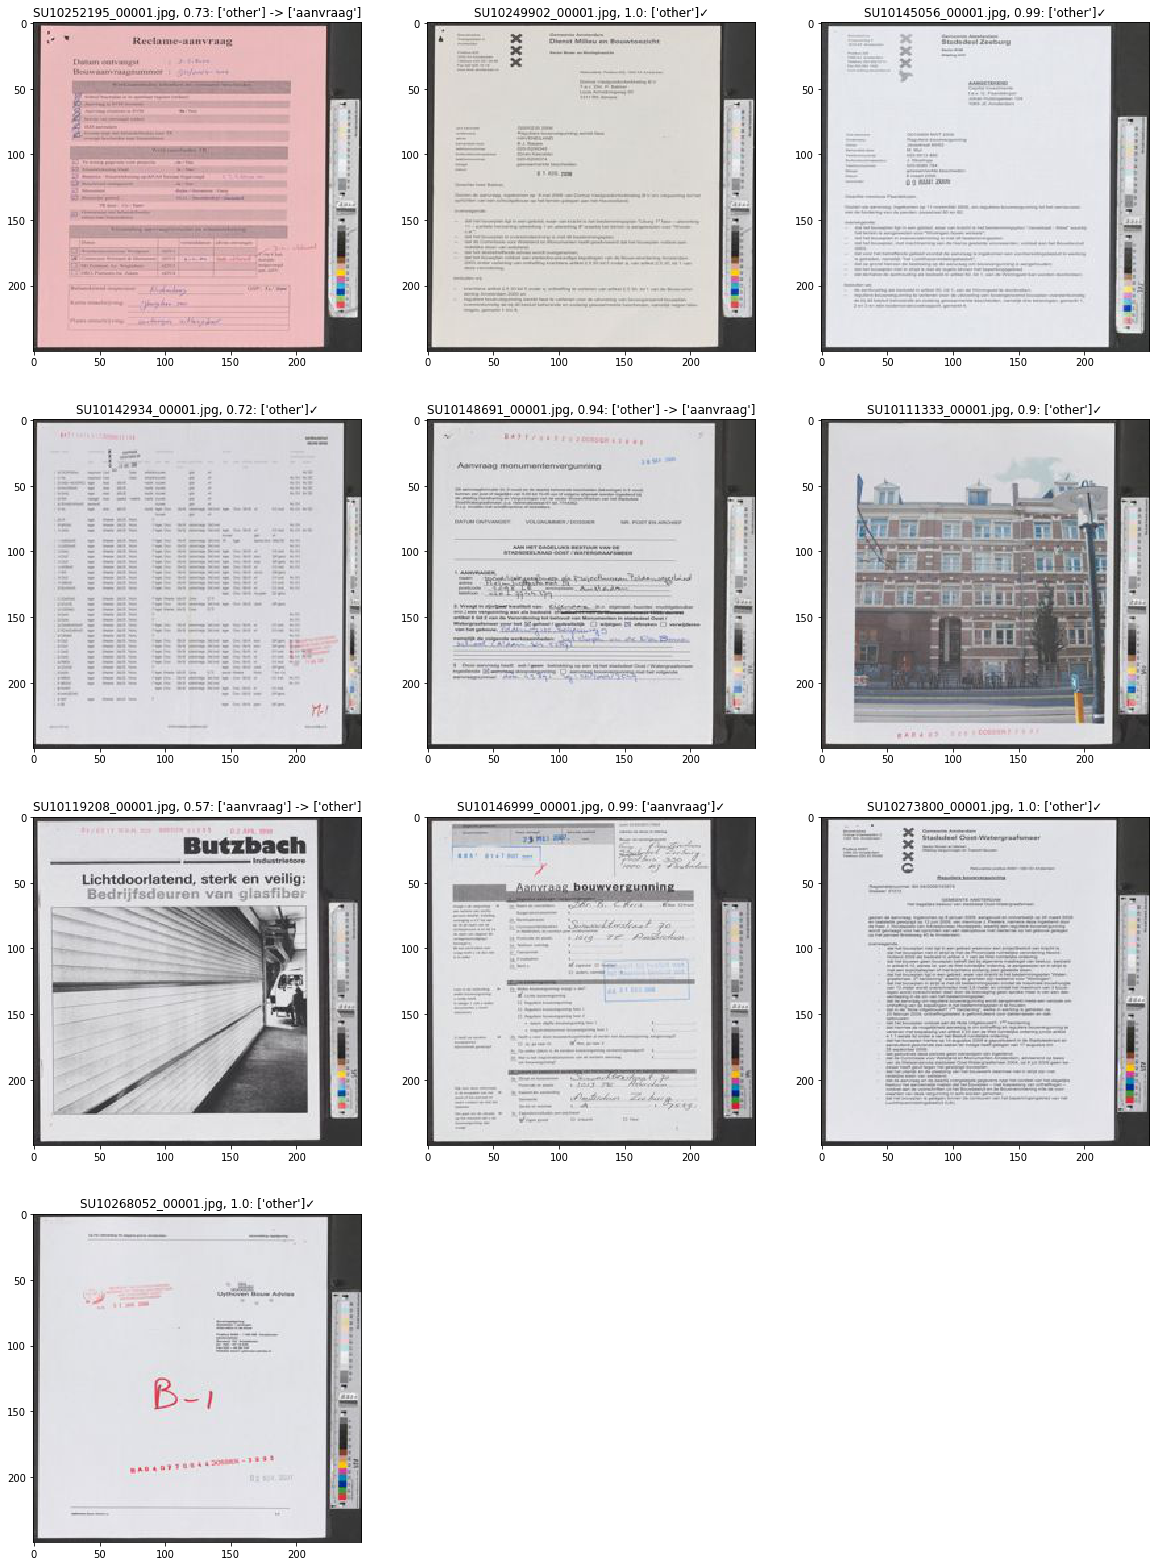

In [17]:
# Z_train_idx = np.argmax(Z_train, axis=1)        
# Z_test_idx = np.argmax(Z_test, axis=1)

print("train set:")
show_prediction_images(
    Xtrain_raw,
    Ztrain,
    predictions_train,
    Ytrain_raw[:, 2],
    encoder,
    10
)

print("test set:")
show_prediction_images(
    Xvalid_raw,
    Zvalid,
    predictions_valid,
    Yvalid_raw[:, 2],
    encoder,
    10
)

In [ ]:
# def multi_class_to_binary(class_true: np.ndarray, class_pred: np.ndarray):
#     # Converting to probablilty that Y_true == 1
#     assert class_true.shape[1] == 2  # 2 classes
#     assert class_pred.shape[1] == 2  # 2 classes
#     assert class_true.shape[0] == class_pred.shape[0]
    
#     y_true = np.argmax(class_true, axis=1)
    
# #     pred_ids = np.argmax(class_pred, axis=1)
# #     y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
#     y_prob = class_pred[:, 1]
#     assert y_true.shape == y_prob.shape
#     return [y_true, y_prob]
    
# [y_true, y_prob] = multi_class_to_binary(Y_test, predictions_test)


In [ ]:
# print(Yvalid[0:20])
# print(np.round(predictions_valid[0:20], 3))
# predictions_valid.shape
# # print(np.round(y_prob[0:10], 3))

In [ ]:
# # class_pred = predictions_test
# # pred_ids = np.argmax(class_pred, axis=1)
# # y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
# y_prob = predictions_valid

In [ ]:
# # reference https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

# n_bins = 5

# print(f'accuracy: {test_acc_str}')
# conf_avg = np.average(predictions_test)
# conf_avg_str = f'{round(conf_avg * 100, 2)}%'
# print(f'confidence avg: {conf_avg_str}')

# def draw_confidence_histogram(y_prob, n_bins):
#     plt.figure()
#     plt.title('Confidence histogram')
#     plt.xlabel("Confidence")
#     plt.ylabel("Sample count")
#     plt.hist(y_prob, bins=n_bins)    
# draw_confidence_histogram(y_prob, n_bins=n_bins)

# def draw_reliability_curve(y_true, y_prob, n_bins):
#     plt.figure()
#     plt.title('Reliability curve')
#     plt.xlabel("Confidence")
#     plt.ylabel("Accuracy")
#     [prob_true_bins, prob_pred_bins] = calibration_curve(y_true, y_prob, n_bins=n_bins)

#     plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     plt.plot(prob_pred_bins, prob_true_bins, marker='s')
# draw_reliability_curve(y_true, y_prob, n_bins)

# Thresholding

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, recall_score

conf_threshold = 0.60
labels = ['aanvraag', 'other']

# Stats calculation by hand
# assert len(labels) == 2
# # in binary case confusion matrix is true postive, true negative etc.
# tn, fp, fn, tp = confusion.ravel()
# # Own recall calculation for sanity check
# recall = tp / (tp + fn)
# print(f'recall: {recall}')

# ROC curve
# assert len(labels) == 2  # only works for binary case
# scores = np.where(prob[:,0]>conf_threshold, 0,1)
# print(y_true[:10, :])
# print((predictions_valid[:10, :]).round(2))
# metrics.roc_curve(y_true, scores, pos_label=2)

#
# 
#
def split_bool_arrays(predictions: np.ndarray, threshold, verbose=False):
    assert predictions.shape[1] == 2, 'expecting binary prediction in one hot format'
    
#     y_pred_class = np.argmax(predictions, axis=1)
    y_pred_conf = np.amax(predictions, axis=1)
    
    if verbose:
        print(y_pred_conf.round(2)[:10])
    
    certain = y_pred_conf >= threshold
    uncertain = np.invert(certain)
    return [certain, uncertain]

def split_uncertain(predictions: np.ndarray, threshold, elements, verbose=False):
    """
    Split all elements into certain and uncertain buckets
    
    @return [[elem1_certain, elem1_uncertain], ...]
    """
    for element in elements:
        assert element.shape[0] == predictions.shape[0], 'number of an element not equal to number of predictions'
    
    [certain, uncertain] = split_bool_arrays(predictions, threshold, verbose=verbose)
    
    results = []
    for element in elements:
        certain_bucket = element[certain]
        uncertain_bucket = element[uncertain]
        results.append([certain_bucket, uncertain_bucket])
    return results
    
results = split_uncertain(predictions_valid, conf_threshold, [Xvalid_raw, Yvalid_raw, Zvalid, predictions_valid])
print('image certain shape: ', results[0][0].shape)
print('image uncertain shape: ', results[0][1].shape)
print('meta certain shape: ', results[1][0].shape)
print('meta uncertain shape: ', results[1][1].shape)

[
    _, # img
    _, # meta
    Zvalid_buckets, # true
    Zvalid_pred_buckets, # prediction
] = results

#


def create_reports(y_true_oh: np.ndarray, y_pred_oh: np.ndarray):
    assert y_true_oh.shape == y_pred_oh.shape
    assert y_true_oh.shape[1] == 2, 'expecting binary one hot inputs'
    y_true = encoder.inverse_transform(y_true_oh)
    y_pred = encoder.inverse_transform(y_pred_oh)
    
#     confusion = confusion_matrix(y_true, y_pred, labels=labels)
#     plt.imshow(confusion, cmap='binary', interpolation='None')
#     plt.show()
#     print(f'confusion matrix:\n{confusion}')
    y_true_pd = pd.Series(y_true.ravel())
    y_pred_pd = pd.Series(y_pred.ravel())
    crosstab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=True)
    
    report = classification_report(y_true, y_pred, target_names=labels)

    return [crosstab, report]


def show_reports(y_true_oh: np.ndarray, y_pred_oh: np.ndarray):
    [crosstab, report] = create_reports(y_true_oh, y_pred_oh)
    print(crosstab)
    
    print()
    print(report)
    

print()
print('--- certain bucket stats ---')
show_reports(Zvalid_buckets[0], Zvalid_pred_buckets[0])

print()
print('--- uncertain bucket stats ---')
show_reports(Zvalid_buckets[1], Zvalid_pred_buckets[1])

image certain shape:  (463, 250, 250, 3)
image uncertain shape:  (6, 250, 250, 3)
meta certain shape:  (463, 4)
meta uncertain shape:  (6, 4)

--- certain bucket stats ---
Predicted  aanvraag  other  All
True                           
aanvraag        153      7  160
other             7    296  303
All             160    303  463

              precision    recall  f1-score   support

    aanvraag       0.96      0.96      0.96       160
       other       0.98      0.98      0.98       303

    accuracy                           0.97       463
   macro avg       0.97      0.97      0.97       463
weighted avg       0.97      0.97      0.97       463


--- uncertain bucket stats ---
Predicted  aanvraag  other  All
True                           
aanvraag          1      1    2
other             2      2    4
All               3      3    6

              precision    recall  f1-score   support

    aanvraag       0.33      0.50      0.40         2
       other       0.67      0.50     

In [23]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


predictions = predictions_valid

def show_results(threshold):
    total = predictions.shape[0]
    [certain, uncertain] = split_bool_arrays(predictions, threshold)
    certain_count = np.sum(certain)
    uncertain_count = np.sum(uncertain)
#     print(certain[:10])
#     print(uncertain[:10])
    
    # Show counts of split
    certain_percentage = certain_count/total*100
    uncertain_percentage = uncertain_count/total*100
    counts_df = pd.DataFrame([
        [certain_count, uncertain_count, total],
        [certain_percentage, uncertain_percentage, 100.0]
    ],
                      columns=['certain', 'uncertain', 'total'],
                      index=['aboslute', 'relative'])
    
    # Show metrics of splits
    [
        Ytrue_buckets,
        Ypred_buckets,
    ] = split_uncertain(predictions, threshold, [Zvalid, predictions_valid])
    
    
    certain_not_empty = Ytrue_buckets[0].shape[0] > 0
    if certain_not_empty:
        y_true = encoder.inverse_transform(Ytrue_buckets[0])
        y_pred = encoder.inverse_transform(Ypred_buckets[0])
        certain_recall = recall_score(y_true, y_pred, pos_label='aanvraag')    
        print(f'certain examples:\t\t{color.BOLD}{round(certain_percentage, 1)}%{color.END}', end='')
        print(f'\t-> recall aanvraag: {color.BOLD}{round(certain_recall*100, 2)}%{color.END}')
    else:
        print(f'certain examples:\t\t{color.BOLD}{round(certain_percentage, 1)}%{color.END}')
    print(f'uncertain examples:\t\t{color.BOLD}{round(uncertain_percentage, 1)}%{color.END}')
    
    print()
    print()
    print(counts_df.round(2))
    
    print()
    print()
    print(f'{color.BOLD}## Certain examples{color.END}')
    if certain_not_empty:
        show_reports(Ytrue_buckets[0], Ypred_buckets[0])
    else:
        print('no data')

    print()
    print()
    print(f'{color.BOLD}## Uncertain examples{color.END}')
    if Ytrue_buckets[1].shape[0] == 0:
        print('no data')
    else:
        show_reports(Ytrue_buckets[1], Ypred_buckets[1])

widget = widgets.FloatSlider(
    value=0.9,
    min=0.5,
    max=1.0,
    step=0.005,
    continuous_update=False,
    description='Threshold:',
    readout=True,
    readout_format='.3f',
)

interact(show_results, threshold=widget);

interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='Threshold:', max=1.0, min=0…

# Output

In [ ]:
def predictions_overview(Y_oh, pred_oh, references, encoder):
    Y_class = encoder.inverse_transform(Y_oh)
    pred_class = encoder.inverse_transform(pred_oh)
    
    data = {'reference': references, 'label': Y_class[:, 0], 'prediction': pred_class[:, 0]}
    df = pd.DataFrame(data)
    
    return df

DIR = './output'
os.makedirs(DIR, exist_ok=True)

df = predictions_overview(Ztrain, predictions_train, Ytrain_raw[:, 2], encoder)
df.to_csv(os.path.join(DIR, 'train_predictions.csv'))
print('---TRAIN---')
print(df)

df = predictions_overview(Zvalid, predictions_valid, Yvalid_raw[:, 2], encoder)
df.to_csv(os.path.join(DIR, 'validation_predictions.csv'))
print('---VALID---')
print(df)

In [ ]:
def write_model(model, directory):
    model_json = model.to_json()
    json_path = os.path.join(directory, "model.json")
    weights_path = os.path.join(directory, "weights.h5")
    with open(json_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weights_path)
    print('done')

write_model(model, MODEL_DIR)
print(f"Model written to {MODEL_DIR}")